In [1]:
# Import Libraries & Load Biometric Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Make plots render inline if running in Jupyter
%matplotlib inline

# Display all columns when inspecting DataFrames
pd.set_option("display.max_columns", None)


In [2]:
# Load and combine all biometric CSV files
bio_paths = [
    "../DATA/api_data_aadhar_biometric/api_data_aadhar_biometric_0_500000.csv",
    "../DATA/api_data_aadhar_biometric/api_data_aadhar_biometric_500000_1000000.csv",
    "../DATA/api_data_aadhar_biometric/api_data_aadhar_biometric_1000000_1500000.csv",
    "../DATA/api_data_aadhar_biometric/api_data_aadhar_biometric_1500000_1861108.csv",
]

Bio_df = pd.concat([pd.read_csv(p) for p in bio_paths], ignore_index=True)

Bio_df.head()

,date,state,district,pincode,bio_age_5_17,bio_age_17_
0,01-03-2025,Haryana,Mahendragarh,123029,280,577
1,01-03-2025,Bihar,Madhepura,852121,144,369
2,01-03-2025,Jammu and Kashmir,Punch,185101,643,1091
3,01-03-2025,Bihar,Bhojpur,802158,256,980
4,01-03-2025,Tamil Nadu,Madurai,625514,271,815


In [3]:
# Data Cleaning & Preprocessing for Biometric Updates
# Convert date to datetime
Bio_df["date"] = pd.to_datetime(Bio_df["date"], format="%d-%m-%Y")

# Standardize state and district names
Bio_df["state"] = Bio_df["state"].str.strip().str.title()
Bio_df["district"] = Bio_df["district"].str.strip().str.title()

# Handle missing values (treat missing counts as 0)
Bio_df[["bio_age_5_17", "bio_age_17_"]] = Bio_df[["bio_age_5_17", "bio_age_17_"]].fillna(0)

# Ensure numeric columns
Bio_df[["bio_age_5_17", "bio_age_17_"]] = Bio_df[["bio_age_5_17", "bio_age_17_"]].astype(int)

# Create total biometric update column
Bio_df["total_bio_updates"] = Bio_df[["bio_age_5_17", "bio_age_17_"]].sum(axis=1)

Bio_df.head()

,date,state,district,pincode,bio_age_5_17,bio_age_17_,total_bio_updates
0,2025-03-01,Haryana,Mahendragarh,123029,280,577,857
1,2025-03-01,Bihar,Madhepura,852121,144,369,513
2,2025-03-01,Jammu And Kashmir,Punch,185101,643,1091,1734
3,2025-03-01,Bihar,Bhojpur,802158,256,980,1236
4,2025-03-01,Tamil Nadu,Madurai,625514,271,815,1086


In [4]:
# Feature Engineering & Aggregations for Biometric Updates

# Extract time features
Bio_df["year"] = Bio_df["date"].dt.year
Bio_df["month"] = Bio_df["date"].dt.month

# State-level aggregation
state_bio = Bio_df.groupby("state")["total_bio_updates"].sum().reset_index()

# Time-series aggregation (monthly)
monthly_bio = (
    Bio_df.groupby(["year", "month"])["total_bio_updates"]
    .sum()
    .reset_index()
)

# District-level aggregation (optional, for drilling down)
district_bio = (
    Bio_df.groupby(["state", "district"])["total_bio_updates"]
    .sum()
    .reset_index()
)

state_bio.head()

,state,total_bio_updates
0,Andaman & Nicobar Islands,2384
1,Andaman And Nicobar Islands,18314
2,Andhra Pradesh,3714633
3,Arunachal Pradesh,72394
4,Assam,982722


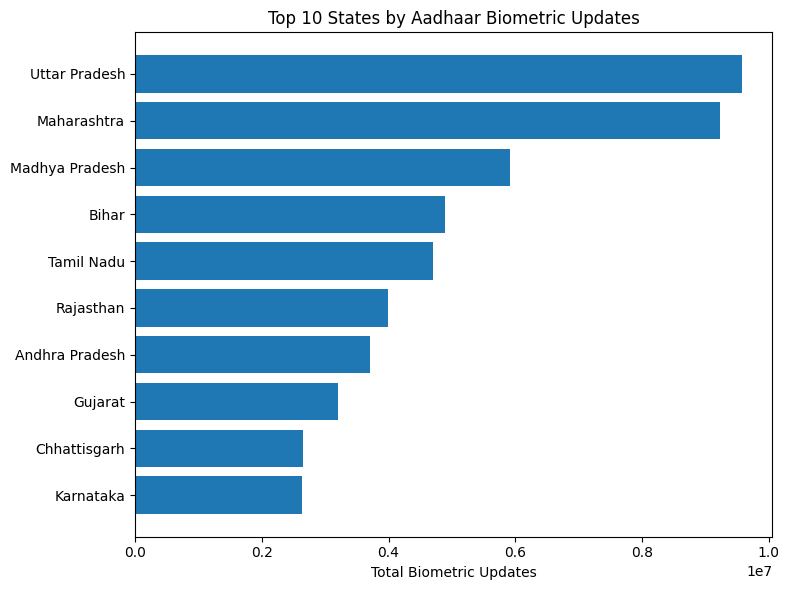

In [5]:
# State-wise Biometric Update Intensity (Top 10 States)

state_bio_sorted = state_bio.sort_values("total_bio_updates", ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(state_bio_sorted["state"].head(10), state_bio_sorted["total_bio_updates"].head(10))
plt.xlabel("Total Biometric Updates")
plt.title("Top 10 States by Aadhaar Biometric Updates")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("../images/bio_top_states.png", dpi=150, bbox_inches="tight")
plt.show()

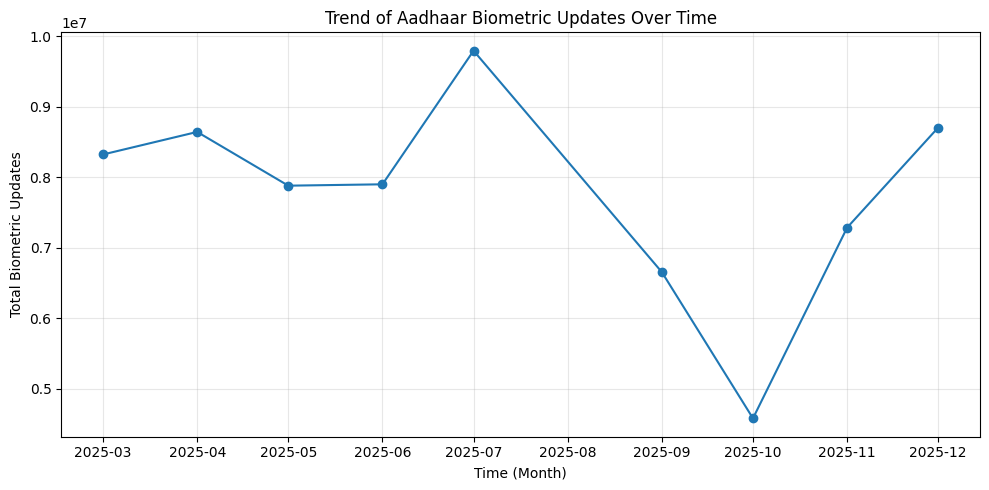

In [6]:
# Time Trend of Biometric Updates (Monthly Aggregation)

monthly_bio["date"] = pd.to_datetime(
    monthly_bio["year"].astype(str) + "-" + monthly_bio["month"].astype(str) + "-01"
)

plt.figure(figsize=(10, 5))
plt.plot(monthly_bio["date"], monthly_bio["total_bio_updates"], marker="o")
plt.xlabel("Time (Month)")
plt.ylabel("Total Biometric Updates")
plt.title("Trend of Aadhaar Biometric Updates Over Time")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../images/bio_trend.png", dpi=150, bbox_inches="tight")
plt.show()

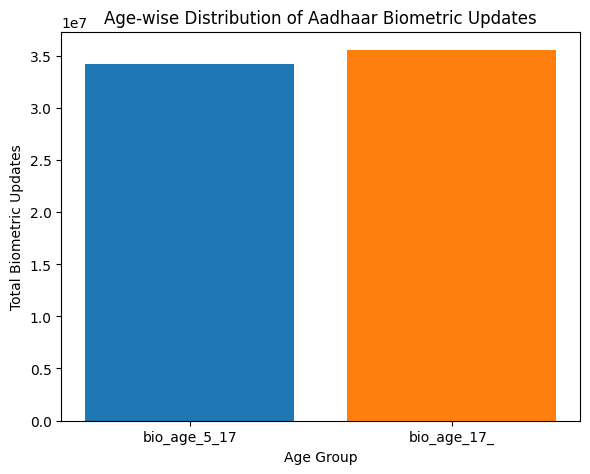

In [7]:
# Age-group Distribution of Biometric Updates (All India)

age_bio_total = Bio_df[["bio_age_5_17", "bio_age_17_"]].sum()

plt.figure(figsize=(6, 5))
plt.bar(age_bio_total.index, age_bio_total.values, color=["#1f77b4", "#ff7f0e"])
plt.xlabel("Age Group")
plt.ylabel("Total Biometric Updates")
plt.title("Age-wise Distribution of Aadhaar Biometric Updates")
plt.tight_layout()
plt.savefig("../images/bio_age_distribution.png", dpi=150, bbox_inches="tight")
plt.show()

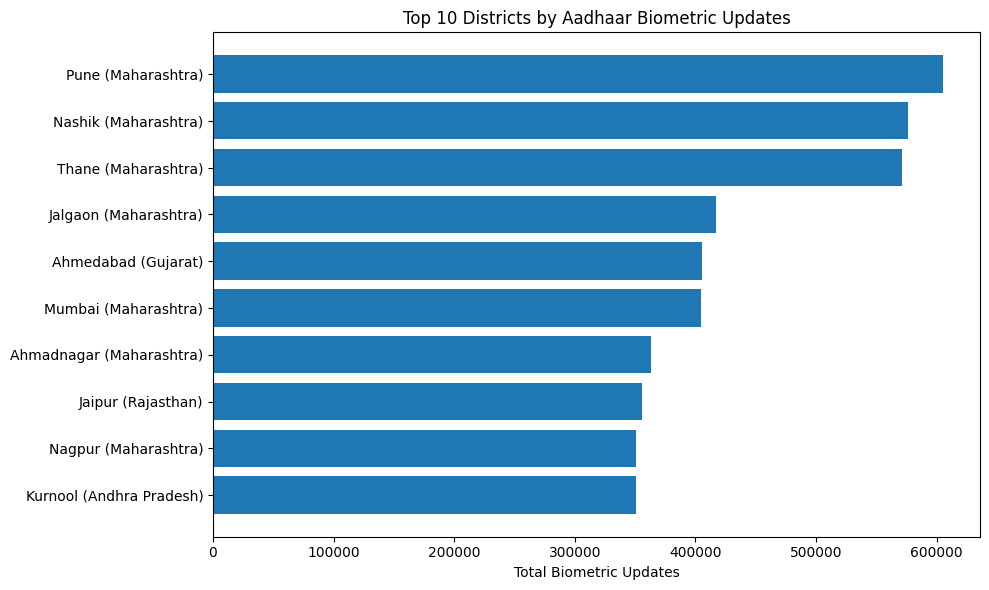

In [8]:
# District-level Hotspots for Biometric Updates (Top 10 Districts)

district_bio_sorted = district_bio.sort_values("total_bio_updates", ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(
    district_bio_sorted["district"] + " (" + district_bio_sorted["state"] + ")",
    district_bio_sorted["total_bio_updates"],
)
plt.xlabel("Total Biometric Updates")
plt.title("Top 10 Districts by Aadhaar Biometric Updates")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("../images/bio_top_districts.png", dpi=150, bbox_inches="tight")
plt.show()

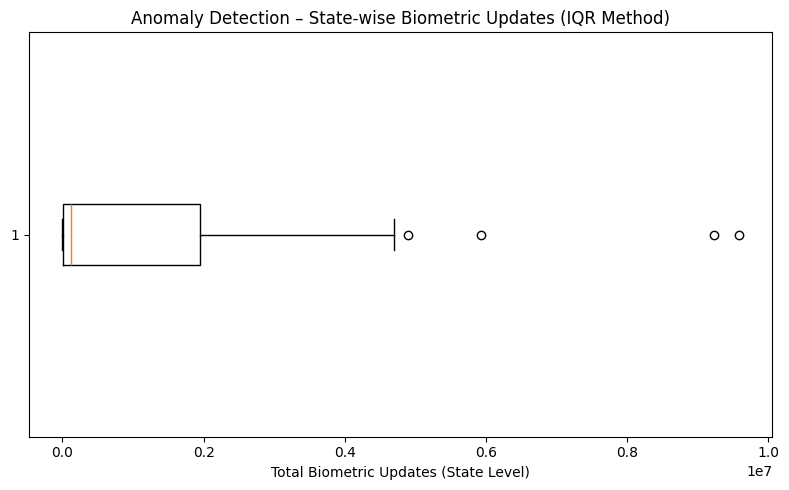

,state,total_bio_updates
43,Uttar Pradesh,9577735
27,Maharashtra,9226139
26,Madhya Pradesh,5923771
5,Bihar,4897587


In [9]:
# Anomaly Detection (State-wise Biometric Updates using IQR)

Q1_bio = state_bio["total_bio_updates"].quantile(0.25)
Q3_bio = state_bio["total_bio_updates"].quantile(0.75)
IQR_bio = Q3_bio - Q1_bio

anomalous_bio_states = state_bio[
    (state_bio["total_bio_updates"] < (Q1_bio - 1.5 * IQR_bio))
    | (state_bio["total_bio_updates"] > (Q3_bio + 1.5 * IQR_bio))
]

plt.figure(figsize=(8, 5))
plt.boxplot(state_bio["total_bio_updates"], vert=False)
plt.xlabel("Total Biometric Updates (State Level)")
plt.title("Anomaly Detection – State-wise Biometric Updates (IQR Method)")
plt.tight_layout()
plt.savefig("../images/bio_anomalies.png", dpi=150, bbox_inches="tight")
plt.show()

anomalous_bio_states.sort_values("total_bio_updates", ascending=False)

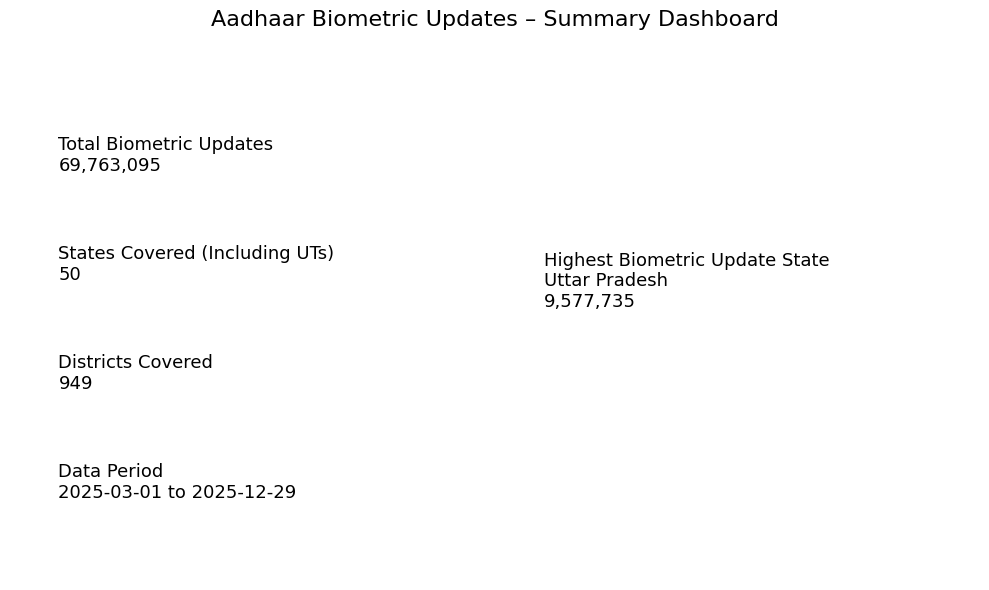

In [10]:
# Summary Dashboard – Aadhaar Biometric Updates

total_bio_updates_overall = Bio_df["total_bio_updates"].sum()
unique_states_bio = Bio_df["state"].nunique()
unique_districts_bio = Bio_df["district"].nunique()
date_range_bio = f"{Bio_df['date'].min().date()} to {Bio_df['date'].max().date()}"

# Top state by biometric updates
top_bio_state = state_bio.sort_values("total_bio_updates", ascending=False).iloc[0]

plt.figure(figsize=(10, 6))
plt.title("Aadhaar Biometric Updates – Summary Dashboard", fontsize=16)

plt.text(0.05, 0.75, f"Total Biometric Updates\n{total_bio_updates_overall:,}", fontsize=13)
plt.text(0.05, 0.55, f"States Covered (Including UTs)\n{unique_states_bio}", fontsize=13)
plt.text(0.05, 0.35, f"Districts Covered\n{unique_districts_bio}", fontsize=13)
plt.text(0.05, 0.15, f"Data Period\n{date_range_bio}", fontsize=13)

plt.text(
    0.55,
    0.5,
    f"Highest Biometric Update State\n{top_bio_state['state']}\n{top_bio_state['total_bio_updates']:,}",
    fontsize=13,
)

plt.axis("off")
plt.tight_layout()
plt.show()